# Определение возраста покупателей

Заказчик - сетевой супермаркет.
Задание - построить модель для распознавания возраста покупателей. (В последствии возраст будет использоваться, в т.ч. для рекомендательных систем).
Представлены данные - набор фотографий с укзаанием фактического возраста

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Загрузим данные и посмотрим наличие некорректной информации

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
#df_labels = labels['file_name']
datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

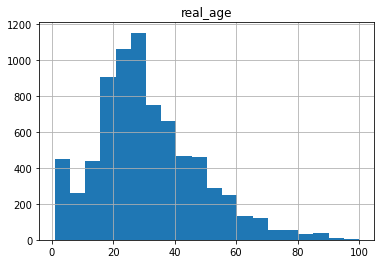

In [6]:
labels.hist(bins=20)

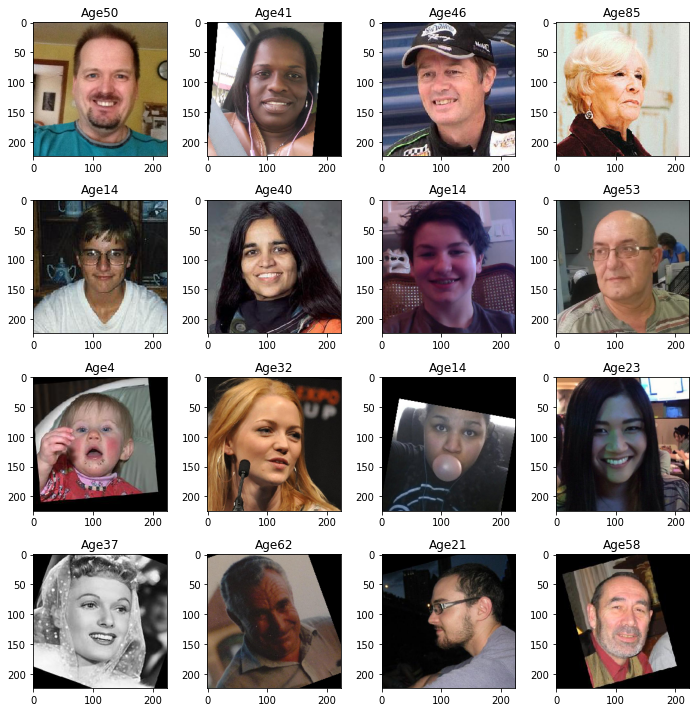

In [7]:
image, label=train_gen_flow.next()
fig = plt.figure(figsize=(10,10))
for _ in range(0,16):
    fig.add_subplot(4,4,_+1)
    #image, label = train_gen_flow.next()
    #image_=image[_]
    #image_=image_[0,:,:,:]
    plt.imshow(image[_], interpolation=None)
    plt.title(('Age'+str(label[_])))
    plt.tight_layout()

<b>Вывод:</b> по результатам загрузки данных ошибок при обращении к файлам не установлено. 

Пропуски или заведомо некорректные значения отсутствуют. 

Основная масса исходных фотографий прходится на возраст 15-50, что должно соотвествовать фактическому составу посетителей супермаркетов. Однако ввиду отсутствия дополнительных данных, делать корректировку не представляется целесообразным.

Представленные для обучения фотографии ориентированы нормально - лица расположены вертикально. Перевернутых изображений нет.

Имеются отдельные черно-белые изображения, котоые могут "отработать" в части ситуаций низкой освещенности.

В части размерности, фотографии занимают большую часть либо все изображения. Фотографии части лица либо с большого расстояния (лицо на фото очень маленькое) также отсутствуют. Выборкой можно пользоваться для обучения без дополнительных корректировок.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

# < скопируйте результат вывода на экран сюда >

# < длинные строки со скачиванием модели можно удалить >


    8192/94765736 [..............................] - ETA: 25s
  139264/94765736 [..............................] - ETA: 36s
  671744/94765736 [..............................] - ETA: 14s
 2703360/94765736 [..............................] - ETA: 5s 
 8282112/94765736 [=>............................] - ETA: 2s
14319616/94765736 [===>..........................] - ETA: 1s
20496384/94765736 [=====>........................] - ETA: 1s
26722304/94765736 [=======>......................] - ETA: 0s
32882688/94765736 [=========>....................] - ETA: 0s
38993920/94765736 [===========>..................] - ETA: 0s
44974080/94765736 [=============>................] - ETA: 0s
50937856/94765736 [===============>..............] - ETA: 0s
56918016/94765736 [=================>............] - ETA: 0s
62930944/94765736 [==================>...........] - ETA: 0s
69042176/94765736 [====================>.........] - ETA: 0s
72646656/94765736 [=====================>........] - ETA: 1s
72663040/94765736 [======================>.......] - ETA: 1s
72679424/94765736 [======================>.......] - ETA: 1s
72728576/94765736 [======================>.......] - ETA: 1s
72810496/94765736 [======================>.......] - ETA: 1s
72990720/94765736 [======================>.......] - ETA: 6s
73007104/94765736 [======================>.......] - ETA: 6s
73039872/94765736 [======================>.......] - ETA: 6s
73089024/94765736 [======================>.......] - ETA: 6s
73170944/94765736 [======================>.......] - ETA: 6s
73351168/94765736 [======================>.......] - ETA: 6s
73596928/94765736 [======================>.......] - ETA: 6s
73875456/94765736 [======================>.......] - ETA: 6s
74153984/94765736 [======================>.......] - ETA: 5s
74448896/94765736 [======================>.......] - ETA: 5s
74760192/94765736 [======================>.......] - ETA: 5s
75087872/94765736 [======================>.......] - ETA: 5s
75415552/94765736 [======================>.......] - ETA: 5s
75776000/94765736 [======================>.......] - ETA: 5s
76152832/94765736 [=======================>......] - ETA: 5s
76546048/94765736 [=======================>......] - ETA: 5s
76955648/94765736 [=======================>......] - ETA: 5s
77381632/94765736 [=======================>......] - ETA: 4s
77824000/94765736 [=======================>......] - ETA: 4s
78299136/94765736 [=======================>......] - ETA: 4s
78790656/94765736 [=======================>......] - ETA: 4s
79314944/94765736 [========================>.....] - ETA: 4s
79872000/94765736 [========================>.....] - ETA: 4s
80445440/94765736 [========================>.....] - ETA: 3s
81051648/94765736 [========================>.....] - ETA: 3s
81690624/94765736 [========================>.....] - ETA: 3s
82345984/94765736 [=========================>....] - ETA: 3s
83050496/94765736 [=========================>....] - ETA: 3s
83771392/94765736 [=========================>....] - ETA: 2s
84541440/94765736 [=========================>....] - ETA: 2s
85344256/94765736 [==========================>...] - ETA: 2s
86196224/94765736 [==========================>...] - ETA: 2s
86589440/94765736 [==========================>...] - ETA: 2s
86605824/94765736 [==========================>...] - ETA: 2s
86638592/94765736 [==========================>...] - ETA: 2s
86687744/94765736 [==========================>...] - ETA: 2s
86769664/94765736 [==========================>...] - ETA: 2s
86949888/94765736 [==========================>...] - ETA: 2s
87310336/94765736 [==========================>...] - ETA: 2s
87949312/94765736 [==========================>...] - ETA: 2s
88621056/94765736 [===========================>..] - ETA: 1s
89341952/94765736 [===========================>..] - ETA: 1s
90079232/94765736 [===========================>..] - ETA: 1s
90865664/94765736 [===========================>..] - ETA: 1s
91668480/94765736 [============================>.] - ETA: 0s
92536832/94765736 [============================>.] - ETA: 0s
93437952/94765736 [============================>.] - ETA: 0s
94273536/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 28s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-08-29 13:07:19.943052: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-29 13:07:20.278206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 52s - loss: 198.8337 - mae: 10.2504 - val_loss: 717.5280 - val_mae: 21.8289
Epoch 2/10
356/356 - 42s - loss: 84.6001 - mae: 7.0246 - val_loss: 223.5687 - val_mae: 11.4104
Epoch 3/10
356/356 - 42s - loss: 59.2355 - mae: 5.8538 - val_loss: 73.3545 - val_mae: 6.4943
Epoch 4/10
356/356 - 41s - loss: 43.4414 - mae: 5.0478 - val_loss: 74.1567 - val_mae: 6.4579
Epoch 5/10
356/356 - 42s - loss: 32.3440 - mae: 4.3446 - val_loss: 68.5855 - val_mae: 6.1470
Epoch 6/10
356/356 - 42s - loss: 25.0627 - mae: 3.8640 - val_loss: 70.2129 - val_mae: 6.2436
Epoch 7/10
356/356 - 43s - loss: 20.6395 - mae: 3.4949 - val_loss: 70.0940 - val_mae: 6.1434
Epoch 8/10
356/356 - 42s - loss: 18.2839 - mae: 3.2330 - val_loss: 68.2892 - val_mae: 6.1301
Epoch 9/10
356/356 - 41s - loss: 16.6941 - mae: 3.0838 - val_loss: 69.4162 - val_mae: 6.2826
Epoch 10/10
356/356 - 41s - loss: 13.6331 - mae: 2.7979 - val_loss: 61.8075 - val_mae: 5.7123
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 61.8075 - mae: 5.7123
Test MAE: 5.7123
```

## Анализ обученной модели

<b>Вывод:</b>
Для выполнения задачи использована библиотек Keras и входящая в нее модель ResNet50.


Использован стандартный рекомендованный подход к формированию обучающихся слоев и параметров модели:
Помимо ResNet50, применен глобальный усредняющий пулинг и выходной слой с одним нейроном, активация Relu т.к. у нас отсутствуют пороговые значения и зависимость в целом линейная, но нам не нужны отрицательные значения предсказаний.
Использован оптимайзер Адам со значением 0.0001, пределенным методом подбора. Выбор оптимайзера основан на отзывах на профильных ресурсах. Указанный оптимайзер позволил выполнить задачу в установленные сроки, выбор другого в рамках поставленной задачи нецелесообразен.
 
Получена модель с результатм метрики MAE=5.7123, что существенно меньше верхнего ограничения в 8.0.

Достигнутые показатели метрики МАЕ позволяют обеспечить заказчика данными в части возраста клиентов при реализации функции рекомендательных систем и др.